# Wavegeometry model pre-process

Prepare the basic state in a zonally averaged atmosphere as input for the wavegeometry model by Nili Harnik and collegues.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import dask
from dask.distributed import Client

In [2]:
%cd
from post_process_IFS_model_output import procedure1
%cd /s2s/wwicker/wavegeometry_model/src
from basicstate import Grid, _filter, buoancy_frequency, pv_gradient
from anywave import rayd

/home/wwicker
/s2s/wwicker/wavegeometry_model/src


In [3]:
# Input directories and filenames
udir = '/s2s/wwicker/data/20180208_91L/model_levels/u/'
tdir = '/s2s/wwicker/data/20180208_91L/model_levels/t/'
lnspdir = '/s2s/wwicker/data/20180208_91L/model_levels/lnsp/'

level_definition = '/s2s/wwicker/wavegeometry_model/input/AandB_91L.txt'

namelist = '/s2s/wwicker/wavegeometry_model/input/nml-IFS-model-level'

outfile = '/s2s/wwicker/wavegeometry_model/input/IFS-model-level-91L.nc'

### Pre-process

In [4]:
%cd /s2s_nobackup/wwicker
client = Client(n_workers=8,threads_per_worker=4,memory_limit='16G')
client

/s2s_nobackup/wwicker


Client Scheduler: tcp://127.0.0.1:38067 Dashboard: /user/wwicker/proxy/8787/status,Cluster Workers: 8 Cores: 32 Memory: 119.21 GiB


In [5]:
# Derive zonal mean from netcdf files
# interpolated to model grid
with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    uobs = procedure1(udir,lnspdir,level_definition,dz=200).mean('number')
    tobs = procedure1(tdir,lnspdir,level_definition,dz=200).mean('number')


 OPEN DATASET:
['u_0.grb']

 OPEN DATASET:
['lnsp_0.grb']

 OPEN DATASET:
['t_0.grb']

 OPEN DATASET:
['lnsp_0.grb']


In [6]:
client.close()

In [7]:
# read the namelist and define model grid
grid = Grid(namelist)

Text(0.5, 1.0, 'Sponge_layer')

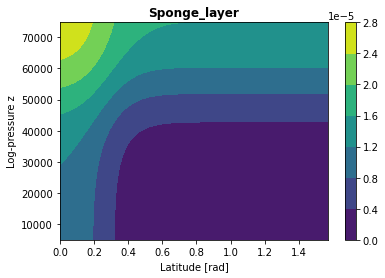

In [8]:
sponge = rayd(grid)

ax = plt.axes()
C = ax.contourf(grid.y,grid.z,sponge)
ax.set_ylabel('Log-pressure z')
ax.set_xlabel('Latitude [rad]')
plt.colorbar(C)
ax.set_title('Sponge_layer',weight='bold')

In [9]:
u = uobs.values
t = tobs.values

In [ ]:
for i in range(10):
    u = _filter(u,-1)
    u = _filter(u,-2)

In [10]:
# calculate squared buoancy frequency and pv gradient from in-situ temperature and zonal wind
N2 = buoancy_frequency(grid,t)
qy = pv_gradient(grid,u,N2)

In [11]:
for i in range(10):
    qy = _filter(qy,-2)

### Plot basic state

Choose either time mean or random timestep

- interp2z fills out of bounds with np.nan
- each convolution extends the area with np.nan
- NaNs are filled for u, N2, and qy

In [12]:
# choose either time mean or random timestep
step = np.random.randint(0,len(grid.t))
#choose = lambda a: a[step,:,:]
choose = lambda a: a.mean(axis=0)
#choose = lambda a: a

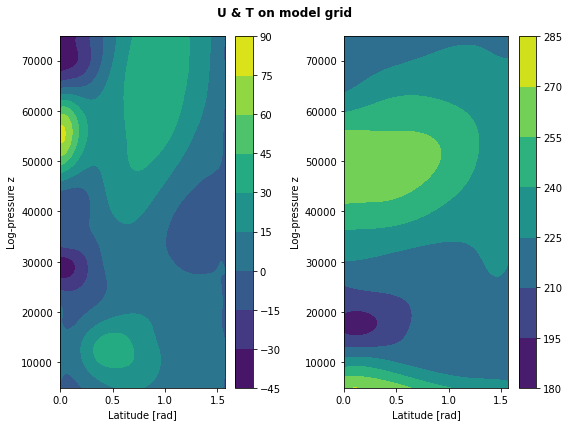

In [13]:
# plot U & T on model grid
fig, axes = plt.subplots(1,2,figsize=(8,6))

Cs = axes[0].contourf(grid.y,grid.z,choose(u))
axes[0].set_ylabel('Log-pressure z')
axes[0].set_xlabel('Latitude [rad]')
plt.colorbar(Cs,ax=axes[0])

Cs = axes[1].contourf(grid.y,grid.z,choose(t))
axes[1].set_ylabel('Log-pressure z')
axes[1].set_xlabel('Latitude [rad]')
plt.colorbar(Cs,ax=axes[1])

fig.suptitle('U & T on model grid',weight='bold')
fig.tight_layout()

#plt_dir = '/s2s/wwicker/plots/wavegeometry_model/'
#plt.savefig(plt_dir+'IFS-model-level-91L_model_grid.png',dpi=300)

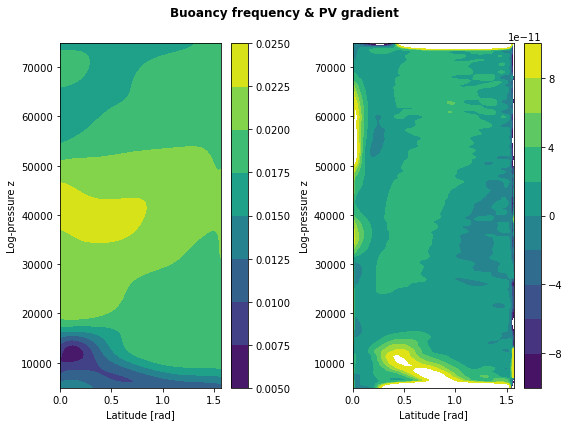

In [14]:
# plot buoancy frequency and pvgradient
fig, axes = plt.subplots(1,2,figsize=(8,6))

Cs = axes[0].contourf(grid.y,grid.z,np.sqrt(choose(N2)))
axes[0].set_ylabel('Log-pressure z')
axes[0].set_xlabel('Latitude [rad]')
plt.colorbar(Cs,ax=axes[0])

levels = np.linspace(-1*10**-10,1*10**-10,11)
Cs = axes[1].contourf(grid.y,grid.z,choose(qy),levels=levels)
axes[1].set_ylabel('Log-pressure z')
axes[1].set_xlabel('Latitude [rad]')
plt.colorbar(Cs,ax=axes[1])

fig.suptitle('Buoancy frequency & PV gradient',weight='bold')
fig.tight_layout()

#plt_dir = '/s2s/wwicker/plots/wavegeometry_model/'
#plt.savefig(plt_dir+'IFS-model-level-91L_basicstate.png',dpi=300)

### Store basic state to outfile